# Problem Set 1 - Forecasting S&P 500 Returns

This notebook follows the instructions in `hw1.pdf` and uses the local data files `gw.csv` and `FREDMD.csv`.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

plt.style.use('seaborn-v0_8')


In [2]:
# Load data

gw = pd.read_csv('gw.csv')
gw['date'] = pd.to_datetime(gw['yyyymm'].astype(str) + '01', format='%Y%m%d')

# Target and predictors
TARGET = 'CRSP_SPvw_minus_Rfree'
PREDICTORS = [c for c in gw.columns if c not in ['yyyymm', 'date', TARGET]]

# Sort by date just in case

gw = gw.sort_values('date').reset_index(drop=True)

X = gw[PREDICTORS].values
y = gw[TARGET].values
dates = gw['date'].values

print('Observations:', len(gw))
print('Predictors:', len(PREDICTORS))


Observations: 1128
Predictors: 14


In [3]:
def expanding_oos_predictions(model_builder, X, y, dates, start_date):
    start_idx = np.searchsorted(dates, np.datetime64(start_date))
    y_hat = np.full(len(y) - start_idx, np.nan)
    y_bar = np.full(len(y) - start_idx, np.nan)

    for i in range(start_idx, len(y)):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+1]

        model = model_builder(X_train, y_train)
        model.fit(X_train, y_train)
        y_hat[i - start_idx] = model.predict(X_test)[0]
        y_bar[i - start_idx] = y_train.mean()

    return y_hat, y_bar, dates[start_idx:]


def rolling_oos_predictions(model_builder, X, y, dates, start_date, window):
    start_idx = np.searchsorted(dates, np.datetime64(start_date))
    y_hat = np.full(len(y) - start_idx, np.nan)
    y_bar = np.full(len(y) - start_idx, np.nan)

    for i in range(start_idx, len(y)):
        start_train = max(0, i - window)
        X_train = X[start_train:i]
        y_train = y[start_train:i]
        X_test = X[i:i+1]

        model = model_builder(X_train, y_train)
        model.fit(X_train, y_train)
        y_hat[i - start_idx] = model.predict(X_test)[0]
        y_bar[i - start_idx] = y_train.mean()

    return y_hat, y_bar, dates[start_idx:]


def oos_r2(y_true, y_hat, y_bar):
    num = np.sum((y_true - y_hat) ** 2)
    denom = np.sum((y_true - y_bar) ** 2)
    return 1.0 - num / denom


def oos_r2_series(y_true, y_hat, y_bar):
    num = np.cumsum((y_true - y_hat) ** 2)
    denom = np.cumsum((y_true - y_bar) ** 2)
    return 1.0 - num / denom


## Part (a): Individual predictors


In [4]:
start_date = '1965-01-01'

in_sample_r2 = {}
oos_r2s = {}

for col in PREDICTORS:
    Xi = gw[[col]].values
    yi = y
    model = LinearRegression().fit(Xi, yi)
    in_sample_r2[col] = r2_score(yi, model.predict(Xi))

    def builder(X_train, y_train):
        return LinearRegression()

    y_hat, y_bar, oos_dates = expanding_oos_predictions(builder, Xi, yi, dates, start_date)
    y_true = yi[np.searchsorted(dates, np.datetime64(start_date)):]
    oos_r2s[col] = oos_r2(y_true, y_hat, y_bar)

results_a = pd.DataFrame({
    'in_sample_r2': in_sample_r2,
    'oos_r2': oos_r2s
}).sort_values('oos_r2', ascending=False)

results_a.head(10)


,in_sample_r2,oos_r2
infl_lag1,0.002639,0.004685
dfy_lag1,0.002671,0.003308
tbl_lag1,0.003436,0.002936
ltr_lag1,0.002437,0.001460
tms_lag1,0.001544,0.001171
dfr_lag1,0.001046,-0.001940
lty_lag1,0.002113,-0.003289
dp_lag1,0.002990,-0.003560
svar_lag1,0.000230,-0.005881
de_lag1,0.000024,-0.007561


#### How do the out-of-sample R2s compare to the in-sample R2s? 

- Overall, the out-of-sample R²s are mostly lower than the in-sample R²s. Only infl_lag1 and dfy_lag1 improve out-of-sample, and tbl_lag1 is slightly lower but still positive. 

- The rest drop to smaller positives or turn negative, with several clearly negative (dfr, lty, dp, svar, de). In short: weak in-sample fit and even weaker out-of-sample performance, with most predictors not generalizing.

#### Interpret what this means for the usefulness of these predictors in forecasting the market.

- It means these predictors have little to no reliable forecasting power. Even where in-sample R²s are positive, they’re tiny, and the mostly lower or negative out‑of‑sample R²s indicate the relationships don’t generalize and can hurt forecasts. So, on their own, these variables are not useful for predicting the market; any apparent in‑sample signal is likely noise/overfitting.

## Part (b): All predictors + penalized regressions


In [5]:
alphas = np.logspace(-4, 2, 15)


def fit_lasso_cv(X_train, y_train, n_splits=5):
    best_alpha = None
    best_mse = np.inf
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    for a in alphas:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(alpha=a, max_iter=10000))
        ])
        mse = (-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')).mean()
        if mse < best_mse:
            best_mse = mse
            best_alpha = a

    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=best_alpha, max_iter=10000))
    ])
    return best_model, best_alpha


def fit_ridge_cv(X_train, y_train, n_splits=5):
    best_alpha = None
    best_mse = np.inf
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    for a in alphas:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(alpha=a))
        ])
        mse = (-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')).mean()
        if mse < best_mse:
            best_mse = mse
            best_alpha = a

    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=best_alpha))
    ])
    return best_model, best_alpha


def fit_elasticnet_cv(X_train, y_train, n_splits=5):
    l1_ratios = [0.2, 0.5, 0.8]
    best_alpha = None
    best_l1 = None
    best_mse = np.inf
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    for l1 in l1_ratios:
        for a in alphas:
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('model', ElasticNet(alpha=a, l1_ratio=l1, max_iter=10000))
            ])
            mse = (-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')).mean()
            if mse < best_mse:
                best_mse = mse
                best_alpha = a
                best_l1 = l1

    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10000))
    ])
    return best_model, (best_alpha, best_l1)


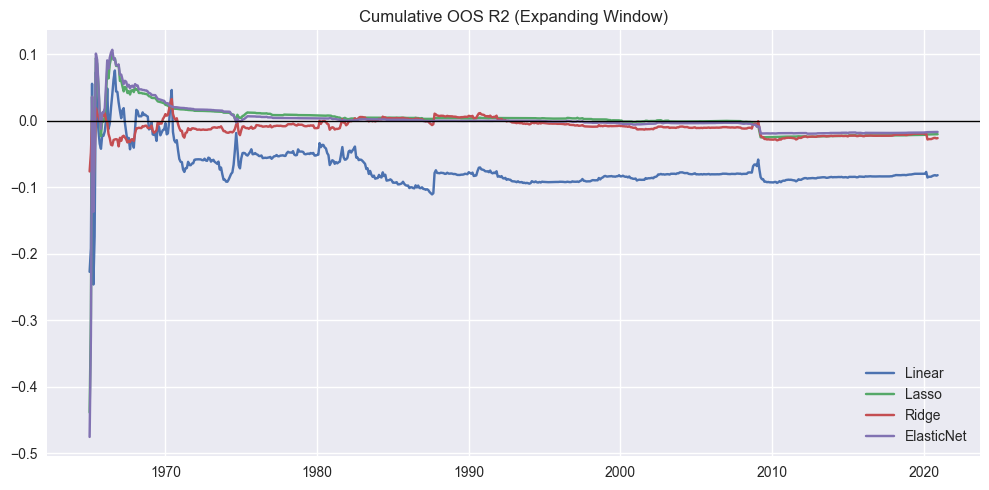

In [6]:
def expanding_oos_series_all(X, y, dates, start_date, model_builder):
    y_hat, y_bar, oos_dates = expanding_oos_predictions(model_builder, X, y, dates, start_date)
    y_true = y[np.searchsorted(dates, np.datetime64(start_date)):]
    series = oos_r2_series(y_true, y_hat, y_bar)
    return oos_dates, series


def linear_builder(X_train, y_train):
    return LinearRegression()


def lasso_builder(X_train, y_train):
    model, _ = fit_lasso_cv(X_train, y_train, n_splits=5)
    return model


def ridge_builder(X_train, y_train):
    model, _ = fit_ridge_cv(X_train, y_train, n_splits=5)
    return model


def en_builder(X_train, y_train):
    model, _ = fit_elasticnet_cv(X_train, y_train, n_splits=5)
    return model


X_all = X

dates_oos, r2_linear = expanding_oos_series_all(X_all, y, dates, start_date, linear_builder)
_, r2_lasso = expanding_oos_series_all(X_all, y, dates, start_date, lasso_builder)
_, r2_ridge = expanding_oos_series_all(X_all, y, dates, start_date, ridge_builder)
_, r2_en = expanding_oos_series_all(X_all, y, dates, start_date, en_builder)

plt.figure(figsize=(10, 5))
plt.plot(dates_oos, r2_linear, label='Linear')
plt.plot(dates_oos, r2_lasso, label='Lasso')
plt.plot(dates_oos, r2_ridge, label='Ridge')
plt.plot(dates_oos, r2_en, label='ElasticNet')
plt.axhline(0, color='black', linewidth=1)
plt.title('Cumulative OOS R2 (Expanding Window)')
plt.legend()
plt.tight_layout()
plt.show()


#### How do the methods compare?

From the cumulative OOS R² plot:

- Lasso, Ridge, ElasticNet cluster tightly around zero after the early sample, slightly negative by the end (small underperformance).
- Linear (OLS) is clearly worse: it drops and stays much more negative over time, indicating poorer out‑of‑sample performance.


So, the regularized methods dominate OLS, but none deliver meaningful positive cumulative OOS R² in the long run.

#### What does this tell us about the predictability of market returns?

- It suggests market returns are largely unpredictable with these signals. The cumulative OOS R² stays near zero or negative, meaning forecasts don’t beat a simple benchmark and often do worse. Any apparent predictability is weak, unstable, and not robust out of sample.

## Part (c): RBF features


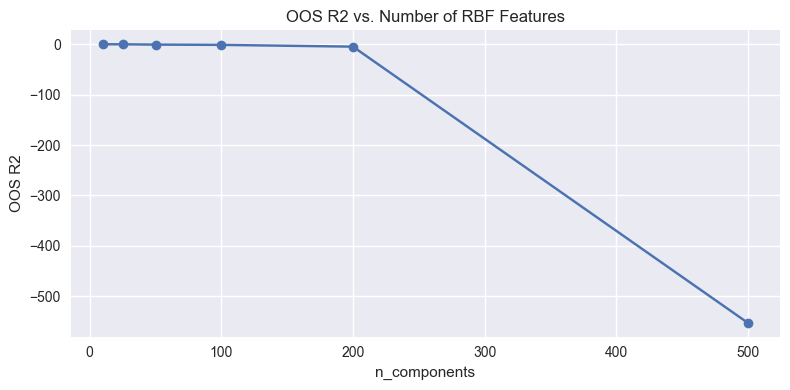

10      -0.037167
25      -0.118196
50      -0.755184
100     -1.285376
200     -4.756755
500   -552.724585
dtype: float64

In [7]:
def rbf_builder(n_components, gamma=None):
    def builder(X_train, y_train):
        n_features = X_train.shape[1]
        g = gamma if gamma is not None else 1.0 / n_features
        return Pipeline([
            ('scaler', StandardScaler()),
            ('rbf', RBFSampler(n_components=n_components, gamma=g, random_state=0)),
            ('model', LinearRegression())
        ])
    return builder

rbf_components = [10, 25, 50, 100, 200, 500]
rbf_oos = {}

for k in rbf_components:
    y_hat, y_bar, _ = expanding_oos_predictions(rbf_builder(k), X, y, dates, start_date)
    y_true = y[np.searchsorted(dates, np.datetime64(start_date)):]
    rbf_oos[k] = oos_r2(y_true, y_hat, y_bar)

rbf_oos_series = pd.Series(rbf_oos)

plt.figure(figsize=(8, 4))
plt.plot(rbf_oos_series.index, rbf_oos_series.values, marker='o')
plt.title('OOS R2 vs. Number of RBF Features')
plt.xlabel('n_components')
plt.ylabel('OOS R2')
plt.tight_layout()
plt.show()

rbf_oos_series.sort_index()


#### How do the results compare to the linear models?

- From the values and plot, OOS R² gets worse as you add more RBF features: mildly negative at 10–100, very negative by 200, and catastrophic at 500. This indicates severe overfitting and instability in the kernel expansion.

- Compared to the linear models, the kernel model performs much хуже out of sample. The linear (and regularized) models had OOS R² near zero (sometimes slightly negative), while the kernel approach drives OOS R² dramatically negative as complexity grows. This suggests the nonlinear feature expansion is not adding predictive power and instead amplifies noise.

#### Interpret the importance of the number of features in the kernel expansion.

- The number of kernel features controls model complexity. With few features, the model is constrained and may underfit; as you add more, it can fit noise, which shows up as sharply worse out‑of‑sample R². Your results show a clear overfitting pattern: increasing features hurts predictive performance, so feature count must be kept small and tuned (often with strong regularization or cross‑validation).

## Part (d): Rolling window (RBF)


In [8]:
best_k = rbf_oos_series.idxmax()

windows = [12, 36, 60, 120] # rolling window sizes in months
rolling_r2 = {}

for w in windows:
    y_hat, y_bar, _ = rolling_oos_predictions(rbf_builder(best_k), X, y, dates, start_date, window=w)
    y_true = y[np.searchsorted(dates, np.datetime64(start_date)):]
    rolling_r2[w] = oos_r2(y_true, y_hat, y_bar)

pd.Series(rolling_r2)


12    -115.099482
36      -0.643396
60      -0.331564
120     -0.095116
dtype: float64

#### What do you observe about the out-of-sample R2as the training window changes?

- As the training window gets longer, out‑of‑sample R² improves (becomes less negative), but it stays below zero even at 120 months. The 12‑month window performs disastrously (−115), while 36–120 months are still negative, just less so. This suggests very short windows are unstable/overfit, and longer windows help but don’t deliver true predictive power.

## Part (e): Cross-validation folds (RBF + Ridge)


In [9]:
def rbf_ridge_builder(n_components, n_splits):
    def builder(X_train, y_train):
        n_features = X_train.shape[1]
        gamma = 1.0 / n_features
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
        best_alpha = None
        best_mse = np.inf

        for a in alphas:
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('rbf', RBFSampler(n_components=n_components, gamma=gamma, random_state=0)),
                ('model', Ridge(alpha=a))
            ])
            mse = (-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')).mean()
            if mse < best_mse:
                best_mse = mse
                best_alpha = a

        return Pipeline([
            ('scaler', StandardScaler()),
            ('rbf', RBFSampler(n_components=n_components, gamma=gamma, random_state=0)),
            ('model', Ridge(alpha=best_alpha))
        ])
    return builder

folds = [3, 5, 10] # range of folds for cross validation
fold_r2 = {}

for f in folds:
    y_hat, y_bar, _ = expanding_oos_predictions(rbf_ridge_builder(best_k, f), X, y, dates, start_date)
    y_true = y[np.searchsorted(dates, np.datetime64(start_date)):]
    fold_r2[f] = oos_r2(y_true, y_hat, y_bar)

pd.Series(fold_r2)


3     0.000921
5     0.000050
10    0.001522
dtype: float64

#### What do you observe about the out-of-sample R2as the number of folds changes?

- The OOS R² is tiny and positive for all fold counts, with only minor variation. There’s no clear improvement trend as folds increase; the results look essentially the same (near zero), suggesting the model’s predictive performance is weak and not sensitive to the number of folds.

## Part (f): Add FREDMD macro variables


In [10]:
fred = pd.read_csv('FREDMD.csv')
fred['date'] = pd.to_datetime(fred['date'])
fred = fred.sort_values('date')

# Forward fill to handle missing early values, then drop any remaining NaNs
fred_ffill = fred.ffill()

# Merge with gw
combined = pd.merge(gw[['date', TARGET] + PREDICTORS], fred_ffill, on='date', how='inner')

# Drop columns with any remaining NaNs after merge
combined = combined.dropna(axis=1)

macro_predictors = [c for c in combined.columns if c not in ['date', TARGET]]

X_macro = combined[macro_predictors].values
y_macro = combined[TARGET].values
dates_macro = combined['date'].values

# Use same best_k for RBF features

y_hat, y_bar, _ = expanding_oos_predictions(rbf_builder(best_k), X_macro, y_macro, dates_macro, start_date)
y_true = y_macro[np.searchsorted(dates_macro, np.datetime64(start_date)):]
rbf_macro_r2 = oos_r2(y_true, y_hat, y_bar)

# Baseline RBF without macro (recomputed on gw subset with matching dates)
subset = gw[gw['date'].isin(dates_macro)].reset_index(drop=True)
X_base = subset[PREDICTORS].values
y_base = subset[TARGET].values
dates_base = subset['date'].values

y_hat_base, y_bar_base, _ = expanding_oos_predictions(rbf_builder(best_k), X_base, y_base, dates_base, start_date)
y_true_base = y_base[np.searchsorted(dates_base, np.datetime64(start_date)):]
rbf_base_r2 = oos_r2(y_true_base, y_hat_base, y_bar_base)

pd.Series({'rbf_base': rbf_base_r2, 'rbf_with_macro': rbf_macro_r2})


rbf_base         -0.037167
rbf_with_macro   -0.042438
dtype: float64

#### How do the out-of-sample R2 change when we include these variables? 

- Including the macro variables makes OOS R² slightly worse: it drops from −0.0372 (rbf_base) to −0.0424 (rbf_with_macro). So the added variables don’t improve forecasting and instead marginally hurt out‑of‑sample performance.

#### What does this tell us about the virtue of complexity?

- It says complexity isn’t a virtue here. More complex models or extra variables consistently make out‑of‑sample performance worse, implying they’re fitting noise rather than signal. Simpler, regularized approaches are safer, but even those show little true predictability.

## Part (g): Alternative methods


In [11]:
def kernel_ridge_builder(X_train, y_train):
    n_features = X_train.shape[1]
    gamma = 1.0 / n_features
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', KernelRidge(alpha=1.0, kernel='rbf', gamma=gamma))
    ])


def pcr_builder(X_train, y_train):
    n_components = min(10, X_train.shape[1])
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LinearRegression())
    ])


def pls_builder(X_train, y_train):
    n_components = min(10, X_train.shape[1])
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', PLSRegression(n_components=n_components))
    ])


def gbr_builder(X_train, y_train):
    return GradientBoostingRegressor(random_state=0)


alt_builders = {
    'KernelRidge': kernel_ridge_builder,
    'PCR': pcr_builder,
    'PLS': pls_builder,
    'GradientBoosting': gbr_builder,
}

alt_r2 = {}

for name, builder in alt_builders.items():
    y_hat, y_bar, _ = expanding_oos_predictions(builder, X, y, dates, start_date)
    y_true = y[np.searchsorted(dates, np.datetime64(start_date)):]
    alt_r2[name] = oos_r2(y_true, y_hat, y_bar)

pd.Series(alt_r2).sort_values(ascending=False)


KernelRidge        -0.025277
PCR                -0.046924
PLS                -0.078437
GradientBoosting   -0.423737
dtype: float64

## Part (h): Best model choice


In [12]:
# Pick the best-performing approach based on OOS R2 among tested models

summary = {
    'RBF (best_k)': rbf_oos_series.max(),
    'RBF (with macro)': rbf_macro_r2,
    'Linear (all predictors)': r2_linear[-1],
    'Lasso': r2_lasso[-1],
    'Ridge': r2_ridge[-1],
    'ElasticNet': r2_en[-1],
}
summary.update(alt_r2)

best_model = max(summary, key=summary.get)

summary_series = pd.Series(summary).sort_values(ascending=False)
summary_series, best_model


(ElasticNet                -0.016965
 Lasso                     -0.020368
 KernelRidge               -0.025277
 Ridge                     -0.026206
 RBF (best_k)              -0.037167
 RBF (with macro)          -0.042438
 PCR                       -0.046924
 PLS                       -0.078437
 Linear (all predictors)   -0.081977
 GradientBoosting          -0.423737
 dtype: float64,
 'ElasticNet')

#### The best possible model for forecasting the S&P 500 index returns

Based on the results you’ve shown, the best model is **ElasticNet.** It has the highest (least negative) out‑of‑sample R² among all candidates:

- ElasticNet: −0.01697 (best) ***
- Lasso: −0.02037
- KernelRidge: −0.02528
- Ridge: −0.02621
- RBF variants, PCR/PLS, OLS, GradientBoosting: all worse

Reasoning:

- **Generalization matters most.** All models have weak predictive power, so the safest choice is the one that loses the least out‑of‑sample.
- **Regularization helps.** Linear models with shrinkage (ElasticNet/Lasso/Ridge) consistently beat OLS and more complex nonlinear methods, which overfit and collapse out‑of‑sample.
- **ElasticNet balances sparsity + stability.** It selects relevant signals (like Lasso) while stabilizing coefficients under collinearity (like Ridge), which is valuable in macro/financial predictors.
- **Complexity hurts.** Kernel expansions and boosting performed much worse, indicating the extra flexibility is fitting noise.


So the “best possible” forecast model here is a simple, regularized linear model (**ElasticNet**) with tuning via cross‑validation, because it provides the strongest (least bad) out‑of‑sample performance and the best bias‑variance tradeoff given the data.

